# Nome: Rafael Silva Del Lama
# Email: rafael.lama@usp.br

# Desafio: 02-FraudDetection

A abordagem adotada foi treinar um modelo de Rede Neural Convolucional que receba como entrada uma imagem de assinatura de referencia e uma imagem de assinatura questionada, e classifique a assinatura questionada como fraude, genuína ou disfarçada. 

Durante o treinamento, cada assinatura questionada foi apresentada a rede com todas as assinaturas de referencia. Já no teste, cada assinatura questionada será avaliada com cada uma das assinaturas de referencia e a classe atribuida a assinatura questionada será definida por voto majoritario.

### Train set

The signature collection for training contains 209 images. The signatures comprise:
    - 9 reference signatures by the same writer “A”;
    - 200 questioned signatures
        - 76 genuine signatures written by the reference writer in his/her normal signature style
        - 104 simulated/forged signatures (written by 27 forgers freehand copying the signature characteristics of the reference writer); 
        - 20 disguised signatures written by the reference writer. 
        
        
The signatures of the training set are arranged according to the following folder structure:

- **Disguised:** Contains all the disguised signatures of specimen author ‘A’
- **Genuine:** Contains all the genuine signatures of specimen author ‘A’
- **Reference:** Contains the reference signatures of specimen author ‘A’ which can be used for training the classifiers for author ‘A’.
- **Simulated:** Contains all the skilled forgeries for specimen author ‘A’

#### Objective

The candidate should provide a classification method that correctly states whether a signature can be a:
- **fraud**
- **genuine**
- **disguised**

## Definição de Funções

### Função responsável por fazer a leitura das imagens.

Parâmetros:
    directory é o diretório contendo as contendo as pastas de cada classe com as respectivas imagens
    input_shape (img_width, img_height, n_chanel)
    
Retornar 3 numpyArrays: 
    1º numpyArray contendo as informações das imagens
    2º numpyArray contendo as classes
    3º numpyArray contendo os labels das imagens

In [1]:
def read_images_from_directory(directory, input_shape) :
    import glob
    import numpy as np
    from PIL import Image
    from scipy import misc
    import cv2
    

    ## Leitura da base de dados
    classes = glob.glob (directory + "/*" ) ## Array contendo o diretorio de cada classe
    print(classes)
    X = []
    y = []
    labels = []
    for i in range(len(classes)): # Para cada diretorio, lê todas as imagens
        files = glob.glob (classes[i] + "/*") 
        for myFile in files: 
            im = Image.open(myFile)
            image = np.array(im)
            image_resized = misc.imresize(image, input_shape)
            
            if(len(image_resized.shape) == 3 and input_shape[2] == 1):
                image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                        
            X.append (image_resized) 
            y.append (classes[i] .split('\\')[1])  ## Array contendo o labels das classes
            labels.append(myFile.split('\\')[2].split('.')[0])
            
    del directory, classes, i, files, myFile, image # Remove as variaveis que nao serao mais utilizadas
    
    return np.asarray(X), np.asarray(y), np.asarray(labels)

In [2]:
def plot_graphs(cnn):
    import matplotlib.pyplot as plt
    %matplotlib inline
    #plt.figure().set_size_inches(20, 8)
    
    # Accuracy vs Validation Accuracy
    plt.figure(0)
    plt.plot(cnn.history['categorical_accuracy'],'r')
    plt.plot(cnn.history['val_categorical_accuracy'],'g')
    plt.xticks(np.arange(0, len(cnn.history['categorical_accuracy']), 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.show()

    # Loss vs Validation Loss
    plt.figure(1)
    plt.plot(cnn.history['loss'],'r')
    plt.plot(cnn.history['val_loss'],'g')
    plt.xticks(np.arange(0, len(cnn.history['categorical_accuracy']), 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

## Parâmetros do algoritmo

In [3]:
# dimensions of our images.
img_width = 200
img_height = 200
img_chanels = 1

train_dir = 'candidate-data/02-FraudDetection/TrainingSet'

K = 5 # número de folds do cross validation

input_shape = (img_width, img_height, img_chanels)   # (img_width, img_height, n_chanel)

## Leitura dos dados ##############################

In [4]:
import numpy as np

In [5]:
X_imagens, y_imagens, labels_imagens = read_images_from_directory(train_dir, input_shape)

['candidate-data/02-FraudDetection/TrainingSet\\Disguise', 'candidate-data/02-FraudDetection/TrainingSet\\Genuine', 'candidate-data/02-FraudDetection/TrainingSet\\Reference', 'candidate-data/02-FraudDetection/TrainingSet\\Simulated']


C:\ProgramData\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [6]:
X_imagens = X_imagens.reshape(X_imagens.shape[0], input_shape[0], input_shape[1], input_shape[2])

Todas as imagens com valor de pixel [0, 1]

In [7]:
X_imagens = X_imagens / 255

Separa as imagens em Referencia e questionadas

In [8]:
X_reference = X_imagens[y_imagens == 'Reference']
y_reference = y_imagens[y_imagens == 'Reference']

X_questioned = X_imagens[y_imagens != 'Reference']
y_questioned = y_imagens[y_imagens != 'Reference']

In [9]:
print('Images Reference: {}'.format(X_reference.shape))
print('Images questioned: {}'.format(X_questioned.shape))

Images Reference: (9, 200, 200, 1)
Images questioned: (200, 200, 200, 1)


# Preparação/limpeza de dados

Como as classes são strings e o classificador que será utilizado aceita apenas valores numéricos, as strings foram transformadas para número
- Disguise -> 0 
- Genuine -> 1 
- Simulated -> 2

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_questioned_encode = labelencoder.fit_transform(y_questioned)

print(labelencoder.classes_)

['Disguise' 'Genuine' 'Simulated']


Como as classes são variáveis categóricas nominais, isto é, não existe ordenação dentre as categorias, os valores númericos foram convertidos para dummy
- 0 -> 1 0 0
- 1 -> 0 1 0
- 2 -> 0 0 1

In [11]:
from keras.utils import np_utils

y_questioned_categorical = np_utils.to_categorical(y_questioned_encode)

Using TensorFlow backend.


Número de amostras de cada classe

In [12]:
import collections

print('Samples:' ,y_questioned.shape[0])
counter = collections.Counter(y_questioned)
print(sorted(counter.items()))

Samples: 200
[('Disguise', 20), ('Genuine', 76), ('Simulated', 104)]


A quantidade de amostras de cada classe está desbalanceada, o que irá afetar a precisão do classificador. Para lidar com este problema, os dois métodos mais comuns de serem aplicados são: Oversampling e undersampling.

Oversampling: consiste em duplicar as observações da classe minoritária para obter um conjunto de dados balanceado, deixando a base de dados com amostras repetidas. Como a classe minoritária (Disguise) possui apenas 20 registros, a aplicação da técnica de oversampling replicaria os registros dessa classe várias vezes (aproximadamente 5 vezes), podendo causar overfitting para esta classe.

Undersampling: Aleatoriamente remove amostras da classe majoritária, com ou sem substituição. Esta técnica pode aumentar a variância do classificador e pode potencialmente descartar amostras úteis ou importantes. Como a classe minoritária (Disguise) possui apenas 20 registros, a aplicação da técnica de undersampling deixaria a base de dados com poucas amostras de cada classe, dificultando o aprendizado.

Outra abordagem é atribuir um peso para cada classe, de forma a atribuir um peso maior para a classe minoritária (e conseguentemente uma punição maior em caso de erro) em relação a classe majoritária. Nesta abordagem não é necessário o equilibrio da base de dados, pois a diferença de pesos atribuido a cada classe compensa o desbalanceamento. Esta última abordagem foi a adotada.

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_questioned_encode), y_questioned_encode)
print('Peso de cada classe:')
print(class_weights)

Peso de cada classe:
[3.33333333 0.87719298 0.64102564]


## Treinamento do modelo de Machine Learning

### Definição do modelo

In [14]:
def create_cnn(input_shape):
    from keras.models import Sequential
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers import concatenate
    from keras.models import Model
    
    InputA = Input(shape=input_shape)
    
    cnn = Conv2D(16, (5, 5), activation = 'relu', strides=3)(InputA) 
    cnn = Dropout(0.3)(cnn)
    cnn = Conv2D(16, (3, 3), activation = 'relu', strides=2)(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Conv2D(16, (2, 2), activation = 'relu', strides=1)(cnn)
    cnn = Dropout(0.3)(cnn)
    
    cnn = Flatten()(cnn)
        
    cnn = Model(inputs=InputA, outputs=cnn)
    
    return cnn

def create_model(input_shape):
    
    from keras.models import Sequential
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers import concatenate
    from keras.models import Model
    
    cnn1 = create_cnn(input_shape)
    cnn2 = create_cnn(input_shape)

    combinedInput = concatenate([cnn1.output, cnn2.output])

    x = Dense(64, activation="relu")(combinedInput)
    x = Dropout(0.3)(x)
    x = Dense(3, activation="softmax")(x)

    model = Model(inputs=[cnn1.input, cnn2.input], outputs=x)
    
    return model  

In [15]:
batch_size = 50
epochs = 25

### Cross Validation para estimar o desempenho do classificador

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=K, shuffle = True)
skf.get_n_splits(X_questioned, y_questioned_encode)

5

FOLD:  1 / 5 TRAIN sets: 159 TEST  sets: 41

Accuracy Test: 96.11%
Confusion Matrix Test:
 [[144   0   0]
 [ 15 477  48]
 [  0   0 747]]

Accuracy Test: 95.14%
Confusion Matrix Test:
 [[ 36   0   0]
 [  5 123  16]
 [  0   0 189]]



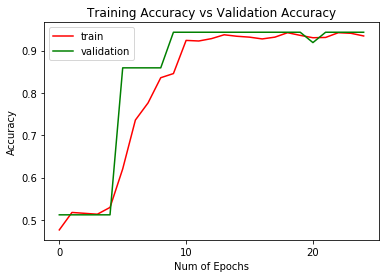

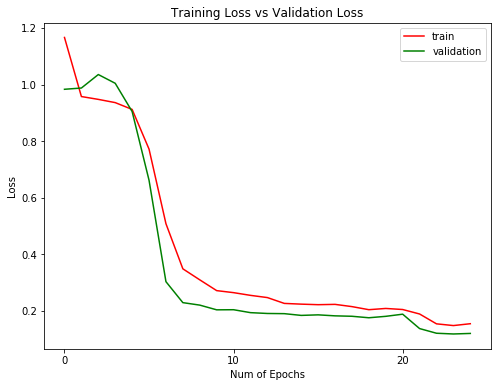

FOLD:  2 / 5 TRAIN sets: 160 TEST  sets: 40

Accuracy Test: 95.81%
Confusion Matrix Test:
 [[144   0   0]
 [ 16 480  53]
 [  0   0 747]]

Accuracy Test: 96.30%
Confusion Matrix Test:
 [[ 36   0   0]
 [  4 120  11]
 [  0   0 189]]



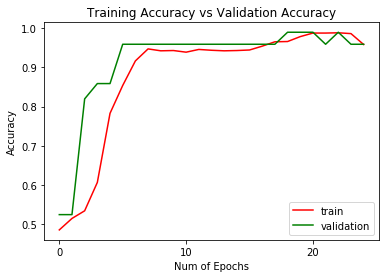

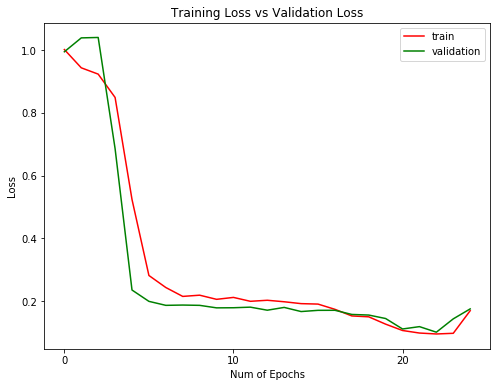

FOLD:  3 / 5 TRAIN sets: 160 TEST  sets: 40

Accuracy Test: 95.81%
Confusion Matrix Test:
 [[144   0   0]
 [ 16 480  53]
 [  0   0 747]]

Accuracy Test: 96.30%
Confusion Matrix Test:
 [[ 36   0   0]
 [  4 120  11]
 [  0   0 189]]



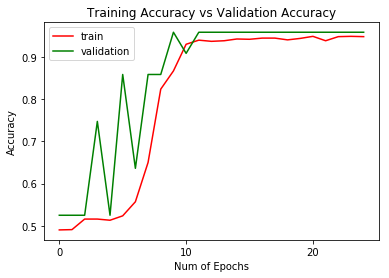

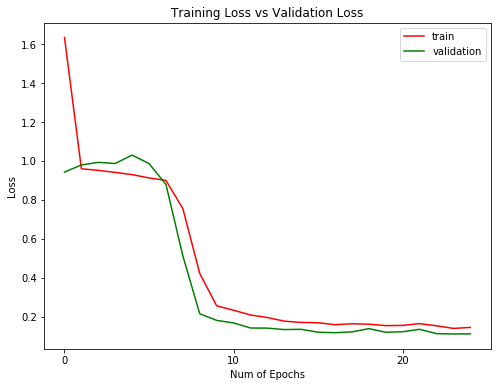

FOLD:  4 / 5 TRAIN sets: 160 TEST  sets: 40

Accuracy Test: 95.81%
Confusion Matrix Test:
 [[144   0   0]
 [ 16 480  53]
 [  0   0 747]]

Accuracy Test: 96.30%
Confusion Matrix Test:
 [[ 36   0   0]
 [  4 120  11]
 [  0   0 189]]



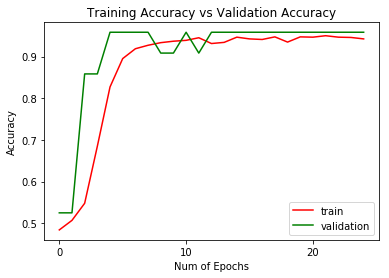

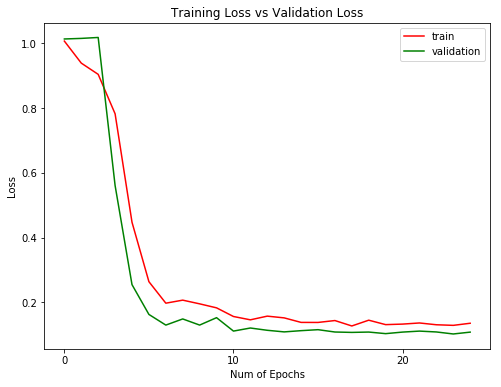

FOLD:  5 / 5 TRAIN sets: 161 TEST  sets: 39

Accuracy Test: 95.99%
Confusion Matrix Test:
 [[144   0   0]
 [ 17 483  49]
 [  0   0 756]]

Accuracy Test: 95.56%
Confusion Matrix Test:
 [[ 36   0   0]
 [  3 117  15]
 [  0   0 180]]



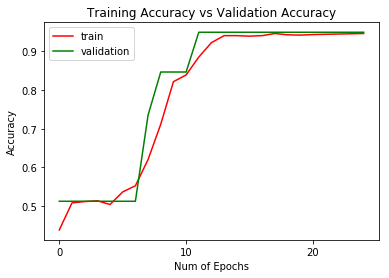

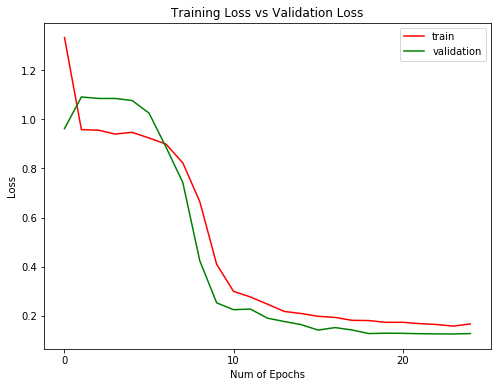

In [17]:
import numpy as np

resultados = [] ## Array para salvar os resultados de cada execução do algoritmo
i = 1

for train_index, test_index in skf.split(X_questioned, y_questioned_encode):  
    
    print("FOLD: ", i, "/", K, "TRAIN sets:", len(train_index), "TEST  sets:", len(test_index))
    i = i + 1
    
    
    X_image_train, X_image_test = X_questioned[train_index], X_questioned[test_index]
    y_train, y_test = y_questioned_categorical[train_index], y_questioned_categorical[test_index]
    
    ##  Repete as imagens questionadas de forma que cada uma delas seja comparada com todas as imagens de referencia    
    new = []
    for _ in range(0, len(X_image_train)):
            new.append(X_reference[0])

    X_reference_train = np.asarray(new)
    
    for j in range(1, len(X_reference)):
        new = []
        for _ in range(0, len(X_image_train)):
            new.append(X_reference[j])

        X_reference_train = np.concatenate((X_reference_train, np.asarray(new)))
    
    X_image_train = np.repeat(X_image_train, len(X_reference), axis=0)     
    y_train = np.repeat(y_train, len(X_reference), axis=0)
    
    new = []
    for _ in range(0, len(X_image_test)):
        new.append(X_reference[0])
        
    X_reference_test = np.asarray(new)  
        
    for j in range(1, len(X_reference)):
        new = []
        for _ in range(0, len(X_image_test)):
            new.append(X_reference[j])

        X_reference_test = np.concatenate((X_reference_test, np.asarray(new)))
    
    X_image_test = np.repeat(X_image_test, len(X_reference), axis=0)     
    y_test = np.repeat(y_test, len(X_reference), axis=0)
       
    classificador = create_model(input_shape)   
    
    classificador.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

    cnn = classificador.fit([X_reference_train, X_image_train], y_train, 
                            validation_data = [[X_reference_test, X_image_test], y_test],
                            epochs = epochs, class_weight = class_weights, batch_size = batch_size,
                            shuffle=True, verbose = 0)       
    
    
    previsoes = classificador.predict([X_reference_train, X_image_train])
    previsoes = [np.argmax(t) for t in previsoes]
    classe_teste = [np.argmax(t) for t in y_train]

    from sklearn.metrics import confusion_matrix, balanced_accuracy_score
    accuracy = balanced_accuracy_score(classe_teste, previsoes)
    matriz = confusion_matrix(classe_teste, previsoes)

    print('\nAccuracy Test: {:.2f}%'.format(accuracy * 100))
    print('Confusion Matrix Test:\n {}\n'.format(matriz))
      
    
    
    previsoes = classificador.predict([X_reference_test, X_image_test], batch_size = batch_size)
    previsoes = [np.argmax(t) for t in previsoes]
    classe_teste = [np.argmax(t) for t in y_test]

    from sklearn.metrics import confusion_matrix, balanced_accuracy_score
    accuracy = balanced_accuracy_score(classe_teste, previsoes)
    matriz = confusion_matrix(classe_teste, previsoes)

    print('Accuracy Test: {:.2f}%'.format(accuracy * 100))
    print('Confusion Matrix Test:\n {}\n'.format(matriz))
    
    resultados.append(accuracy)
    
    plot_graphs(cnn)
    
    del X_reference_train
    del X_image_train
    del y_train
    del classificador
    del cnn

In [18]:
from statistics import mean, stdev
print('Max: ', max(resultados))
print('Min: ', min(resultados))
print('Média: ', mean(resultados))
print('SD: ', stdev(resultados))

Max:  0.9629629629629629
Min:  0.9513888888888888
Média:  0.9591666666666666
SD:  0.00540299794847967


### Treinamento do modelo final

Repete as imagens questionadas de forma que cada uma delas seja comparada com todas as imagens de referencia

In [19]:
new = []
for _ in range(0, len(X_questioned)):
    new.append(X_reference[0])

X_reference_train = np.asarray(new)
    
for j in range(1, len(X_reference)):
    new = []
    for _ in range(0, len(X_questioned)):
        new.append(X_reference[j])

    X_reference_train = np.concatenate((X_reference_train, np.asarray(new)))
    
X_image_train = np.repeat(X_questioned, len(X_reference), axis=0)     
y_train = np.repeat(y_questioned_categorical, len(X_reference), axis=0)

In [20]:
print("X_reference_train: {}".format(X_reference_train.shape))
print("X_image_train: {}".format(X_image_train.shape))
print("y_train: {}".format(y_train.shape))

X_reference_train: (1800, 200, 200, 1)
X_image_train: (1800, 200, 200, 1)
y_train: (1800, 3)


In [21]:
classificador = create_model(input_shape)   
    
classificador.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

cnn = classificador.fit([X_reference_train, X_image_train], y_train, 
                        epochs = epochs, class_weight = class_weights, batch_size = batch_size,
                        shuffle=True, verbose = 0)       
    

In [22]:
previsoes = classificador.predict([X_reference_train, X_image_train])
previsoes = [np.argmax(t) for t in previsoes]
classe_teste = [np.argmax(t) for t in y_train]

from sklearn.metrics import confusion_matrix, balanced_accuracy_score
accuracy = balanced_accuracy_score(classe_teste, previsoes)
matriz = confusion_matrix(classe_teste, previsoes)

print('\nAccuracy Test: {:.2f}%'.format(accuracy * 100))
print('Confusion Matrix Test:\n {}\n'.format(matriz))


Accuracy Test: 95.91%
Confusion Matrix Test:
 [[180   0   0]
 [ 20 600  64]
 [  0   0 936]]



### Salvar H5

In [23]:
classificador_json = classificador.to_json()
with open('nuveo.json', 'w') as json_file:
    json_file.write(classificador_json)
classificador.save_weights('nuveo.h5')